In [3]:
import sys
sys.path.insert(0, '..')

In [4]:
# Basic imports
import jax.numpy as np
import jax.random as jr
import jax.scipy as jsp
import jax
import numpy

#jax.config.update("jax_enable_x64", True)

# Optimisation imports
import zodiax as zdx
import optax

# dLux imports
import dLux as dl
import dLux.utils as dlu

#jax.config.update("jax_enable_x64", True)


#import chainconsumer as cc
# Visualisation imports
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib

plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72

from detectors import *
from apertures import *
from models import *
from fisher import *
from stats import posterior
from fitting import *
from plotting import *

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72
plt.rcParams["font.size"] = 24

def set_array(pytree):
    dtype = np.float64 if jax.config.x64_enabled else np.float32
    floats, other = eqx.partition(pytree, eqx.is_inexact_array_like)
    floats = jtu.tree_map(lambda x: np.array(x, dtype=dtype), floats)
    return eqx.combine(floats, other)

In [5]:
jax.__version__

'0.6.2'

In [6]:
wid = 64
oversample = 4

nwavels = 20
npoly=5

psf_oversample = 4

optics = NICMOSOptics(512, wid, oversample)
oversampled_optics = NICMOSOptics(512, wid, oversample*psf_oversample, psf_oversample=psf_oversample)


detector = NICMOSDetector(oversample, wid)

ddir = "../data/MAST_2024-09-22T03_37_01.724Z/HST/"


files = [
    #'n8yj53vfq_cal.fits'

    'n8yj59glq_cal.fits',

]

exposures_single = [exposure_from_file(ddir + file, SinglePointPolySpectrumFit(nwavels), crop=wid) for file in files]
exposures_binary = [exposure_from_file(ddir + file, BinaryPolySpectrumFit(nwavels), crop=wid) for file in files]

/var/folders/hv/659ls99s2sjd7m3dfr17k8cm0000gn/T/ipykernel_38357/724098725.py:25: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  exposures_single = [exposure_from_file(ddir + file, SinglePointPolySpectrumFit(nwavels), crop=wid) for file in files]
/var/folders/hv/659ls99s2sjd7m3dfr17k8cm0000gn/T/ipykernel_38357/724098725.py:26: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  exposures_binary = [exposure_from_file(ddir + file, BinaryPolySpectrumFit(nwavels), crop=wid) for file in files]


In [7]:
params = {
    #"fluxes": {},
    "positions": {},
    "spectrum": {},
    "aberrations": {},
    "cold_mask_shift": {},
    "cold_mask_rot": {},
    "cold_mask_scale": {},
    "cold_mask_shear": {},
    "primary_scale": {},
    "primary_rot": {},
    "primary_shear": {},
    "outer_radius": 1.2*0.955,
    "secondary_radius": 0.372*1.2,
    "spider_width": 0.077*1.2,
    "scale": 0.0432,
    "rot": 0.,
    "softening": 2.,
    "bias": {}
}

for exp in exposures_single:
    params["positions"][exp.fit.get_key(exp, "positions")] = np.asarray([0.,0.])
    params["spectrum"][exp.fit.get_key(exp, "spectrum")] = np.zeros(npoly).at[0].set(1)*np.log10(np.nansum(exp.data)/nwavels)
    params["aberrations"][exp.fit.get_key(exp, "aberrations")] = np.zeros(26)
    params["cold_mask_shift"][exp.fit.get_key(exp, "cold_mask_shift")] = -np.asarray([-0.06, -0.06])*1e2
    params["cold_mask_rot"][exp.fit.get_key(exp, "cold_mask_rot")] = -45.
    params["cold_mask_scale"][exp.fit.get_key(exp, "cold_mask_scale")] = np.asarray([1.,1.])
    params["cold_mask_shear"][exp.fit.get_key(exp, "cold_mask_shear")] = np.asarray([0.,0.])
    params["primary_rot"][exp.fit.get_key(exp, "primary_rot")] = -45. #+ 180.
    params["primary_scale"][exp.fit.get_key(exp, "primary_scale")] = np.asarray([1.,1.])
    params["primary_shear"][exp.fit.get_key(exp, "primary_shear")] = np.asarray([0.,0.])

    params["bias"][exp.fit.get_key(exp, "bias")] = 0.

model_normal = set_array(NICMOSModel(exposures_single, params, optics, detector))
model_oversampled = set_array(NICMOSModel(exposures_single, params, oversampled_optics, detector))

model_binary = set_array(NICMOSModel(exposures_binary, params, optics, detector))


params = ModelParams(params)

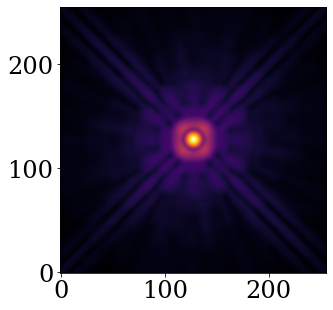

In [8]:
# generate oversampled PSF
psf = exposures_single[0].fit(model_oversampled,exposures_single[0])
plt.imshow(psf**0.25)

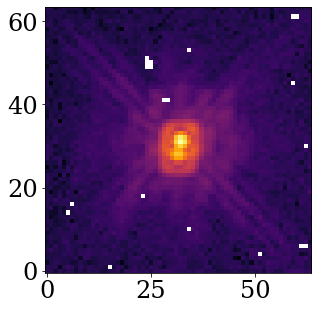

In [9]:
plt.imshow(exposures_single[0].data**0.125)

In [10]:
# Shrish's FFT shifting code
fft, ifft, fftshift = np.fft.fft2, np.fft.ifft2, np.fft.fftshift
rfft, irfft, rfftfreq = np.fft.rfft2, np.fft.irfft2, np.fft.rfftfreq

def reposition(image,dx,dy):
    '''
    Shift an image by dx, dy pixels using FFT

    Parameters
    ----------
    image : ndarray
        2D image to be shifted
    dx : float
        shift in x direction
    dy : float
        shift in y direction
    
    Returns
    -------
    shifted_image : ndarray
        2D image shifted by dx, dy
    
    '''

    # Get the shape of the image
    Nx, Ny = image.shape

    # Create the frequency grid
    kx = fftshift(np.fft.fftfreq(Nx, d=1.))
    ky = fftshift(np.fft.fftfreq(Ny, d=1.))

    # Create the phase ramp
    phase_ramp = np.exp(-2.j*np.pi*(kx[:,None]*dx + ky[None,:]*dy))

    # Shift the image in Fourier space
    shifted_image = fftshift(ifft(fft(fftshift(image))*fftshift(phase_ramp)))

    return np.abs(shifted_image) 

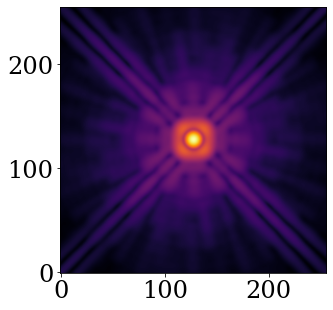

In [11]:
plt.imshow(reposition(psf, 0, 0)**0.125)

In [12]:
def fit_flux(exp, template):

    psf = template.flatten()

    bad = exp.bad.flatten()
    err = exp.err.flatten()

    psf= np.where(exp.bad.flatten(), 0., psf)

    psf = psf/np.sum(psf)

    data = exp.data.flatten()
        #data= data.at[exp.bad.flatten()].set(0.)
    data= np.where(exp.bad.flatten(), 0., data)


    design = np.transpose(np.vstack((np.ones(len(psf)), psf)))

    flux_raw, _, _, _ = np.linalg.lstsq(design, data)
    true_flux = flux_raw[1]        
    #true_flux= np.log10(flux_raw[1]/nwavels * 2/(1+contrast)) - spec
        #print(true_flux)
    
    return -np.sum(np.where(bad, 0., jsp.stats.norm.logpdf(psf*true_flux, data, err))), true_flux#loss(template*true_flux, exp)

In [13]:
@zdx.filter_jit
def grid_loss_single(dx, dy):
    psf_shifted = dlu.downsample(reposition(psf, dx*psf_oversample,dy*psf_oversample), psf_oversample)
    return fit_flux(exposures_single[0], psf_shifted)[0]

In [14]:
Nx, Ny = 50, 50

xs = np.linspace(-5, 5, Nx)
ys = np.linspace(-5, 5, Ny)

losses = np.zeros((Nx, Ny))

for i, dx in enumerate(xs):
    for j, dy in enumerate(ys):
        #print(grid_loss(dx,dy))
        losses = losses.at[i,j].set(grid_loss_single(dx,dy))
        #psf_shifted = dlu.downsample(reposition(psf, dx*psf_oversample,dy*psf_oversample), psf_oversample)
        #losses = losses.at[i,j].set(fit_flux(exposures_single[0], psf_shifted))

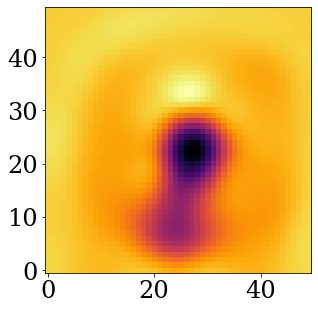

In [15]:
plt.imshow(losses)

In [16]:
xi, yi = np.unravel_index(losses.argmin(), losses.shape)
xp, yp = xs[xi], ys[yi]
print(xp, yp)

-0.5102041 0.51020384


In [17]:
@zdx.filter_jit
def grid_loss_binary(dx1, dy1, r, theta, contrast, return_flux = False, return_psf = False):
    ang = dlu.deg2rad(theta)
    dx2 = dx1-r*np.cos(ang)
    dy2 = dy1-r*np.sin(ang)
    #dx1 = dx1+r*np.sin(ang)/2
    #dy1 = dy1+r*np.cos(ang)/2
    primary_shifted = reposition(psf, dx1*psf_oversample,dy1*psf_oversample)
    secondary_shifted = reposition(psf, dx2*psf_oversample,dy2*psf_oversample)
    f1, f2 = dlu.fluxes_from_contrast(1, contrast)
    psf_total = dlu.downsample(f1*primary_shifted + f2*secondary_shifted, psf_oversample)
    if return_psf:
        return psf_total
    if return_flux:
        return fit_flux(exposures_single[0], psf_total)
    return fit_flux(exposures_single[0], psf_total)[0]

In [18]:
Nx, Ny, Nc = 20, 50, 20

rs = np.linspace(0, 5, Nx)
thetas = np.linspace(-180, 180, Ny)
cs = 10**(np.linspace(0, 1, Nc))


losses = np.zeros((Nx, Ny, Nc))

for i, r in enumerate(rs):
    for j, theta in enumerate(thetas):
        for k, c in enumerate(cs):
            losses = losses.at[i,j, k].set(grid_loss_binary(xp,yp, r, theta, c))

In [19]:
ri, ti, ci = np.unravel_index(losses.argmin(), losses.shape)
rs, ts, cont = rs[ri], thetas[ti], cs[ci]
print(rs, ts, cont)

3.1578948 11.020402 2.3357215


In [20]:
best_flux = grid_loss_binary(xp,yp, rs, ts, cont, return_flux=True)[1]
true_best_flux = true_flux= np.log10(best_flux/nwavels * 2/(1+cont)) - np.log10(np.nansum(exp.data)/nwavels)

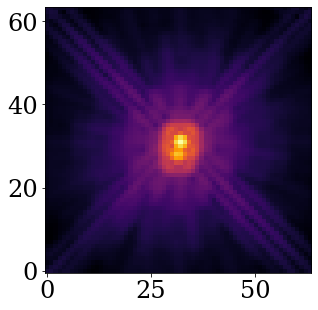

In [21]:
plt.imshow(grid_loss_binary(xp,yp, rs, ts, cont, return_psf=True)**0.125)

In [22]:
#stop

In [23]:
def extract_binary_params(params, exposures, x, y, theta, r, flux, contrast):
    ang = dlu.deg2rad(theta)

    #fluxes = dlu.fluxes_from_contrast(flux, contrast)
    param_dict = params.params.copy()
    param_dict["primary_spectrum"] = param_dict["spectrum"]
    param_dict["secondary_spectrum"] = param_dict["spectrum"]
    param_dict["fluxes"] = dlu.list2dictionary([(exp.fit.get_key(exp, "fluxes"), flux) for exp in exposures], ordered=True)#tree_mul(param_dict["spectrum"], fluxes[0])
    param_dict["contrast"] = dlu.list2dictionary([(exp.fit.get_key(exp, "contrast"), contrast) for exp in exposures], ordered=True) #tree_mul(param_dict["spectrum"], fluxes[1])
    param_dict["positions"] = dlu.list2dictionary([(exp.fit.get_key(exp, "positions"), np.array([y-r*np.sin(ang)/2,x-r*np.cos(ang)/2])) for exp in exposures], ordered=True)#np.array([x,y])
    param_dict["separation"] = r#dlu.list2dictionary([(exp.fit.get_key(exp, "separation"), r) for exp in exposures])
    param_dict["position_angle"] = theta#-theta+90 #dlu.list2dictionary([(exp.fit.get_key(exp, "position_angle"), theta) for exp in exposures])
    return ModelParams(param_dict)

In [24]:
binary_params = extract_binary_params(params, exposures_binary, xp, yp, ts, rs, true_best_flux, cont)
model_binary = set_array(NICMOSModel(exposures_binary, binary_params.params, optics, detector))


In [25]:
binary_params.params

{'positions': OrderedDict([('n8yj59glq',
               Array([ 0.20837456, -2.0600343 ], dtype=float32))]),
 'spectrum': {'U20081_F110W': Array([2.3654337, 0.       , 0.       , 0.       , 0.       ], dtype=float32)},
 'aberrations': {'n8yj59glq': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)},
 'cold_mask_shift': {'53255': Array([6., 6.], dtype=float32)},
 'cold_mask_rot': {'global': -45.0},
 'cold_mask_scale': {'F110W': Array([1., 1.], dtype=float32)},
 'cold_mask_shear': {'F110W': Array([0., 0.], dtype=float32)},
 'primary_scale': {'F110W': Array([1., 1.], dtype=float32)},
 'primary_rot': {'F110W': -45.0},
 'primary_shear': {'F110W': Array([0., 0.], dtype=float32)},
 'outer_radius': 1.146,
 'secondary_radius': 0.44639999999999996,
 'spider_width': 0.0924,
 'scale': 0.0432,
 'rot': 0.0,
 'softening': 2.0,
 'bias': {'n8yj59glq': 0.0},
 'primary_spectrum': {'U20081_F110W': Array([2.3654337, 0.   

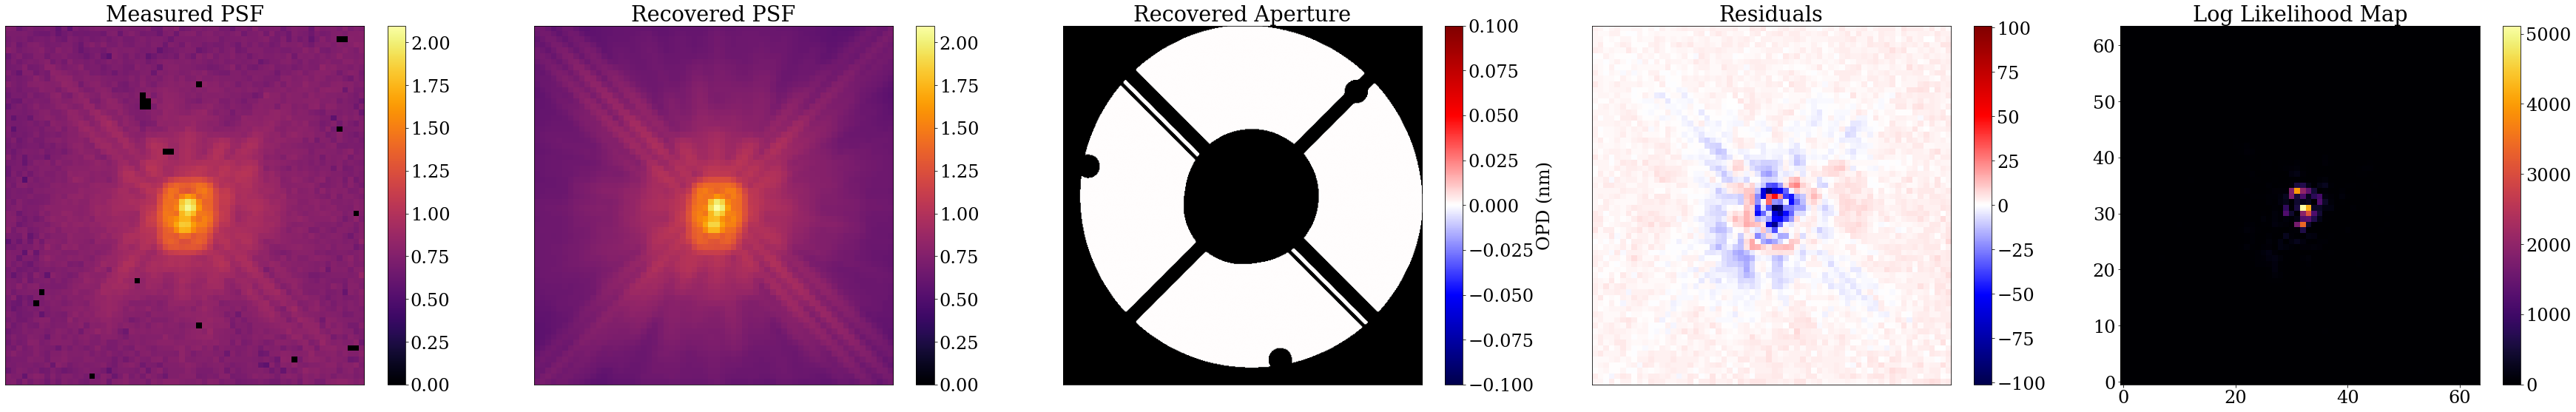

In [26]:
plot_comparison(model_binary, binary_params, exposures_binary)